#### Importing the neccessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import re
from transformers import pipeline,  AutoTokenizer, AutoModelForSequenceClassification
import torch
import seaborn
import openai

/Users/gt-europe/Documents/RediQuest-/turmerik/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gt-europe/Documents/RediQuest-/turmerik/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Loading the variables

In [3]:
load_dotenv()

# Access the variables
client_id = os.getenv("APP_ID")
client_secret = os.getenv("CLIENT_SECRET")
user_agent = os.getenv("USER_AGENT")
openai.api_key = os.getenv("OPENAI_API_KEY")

In [4]:
import praw
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    user_name= "RediQuest",
)


#### Verifying Authentication

In [5]:
# Access a public subreddit to verify authentication
subreddit = reddit.subreddit("test")  # "test" is a public, general subreddit

# Fetch and print the titles of the top 5 posts in the "test" subreddit
for post in subreddit.hot(limit=5):
    print(post.title)


Some test commands
Testing 123
test2 title
test1 title
New post test comment 04/11/2024 12:49:46


#### Example: Fetching posts from a subreddit

In [6]:

subreddit = reddit.subreddit("clinicaltrials")
for post in subreddit.hot(limit=10):
    print(post.title)

Clinical Trials Discussion Thread - Week of 2021-07-18
Consider supporting clinical research education and accessibility this holiday season by making a donation to our Boston-based nonprofit.
Seeking Feedback from Pregnant & Post-Partum Patients Living with Moderate to Severe Medical Conditions
The Story of Mucinex - How a Common Drug Became a Household Name
Webinar Tomorrow: Hear how experiential data and feedback from the patient's point of view can shape the future of clinical trials in a free 15-minute FLASH webinar 11/2 at 12pm EST.
Video on Eroom's Law (Opposite of Moore's Law for Pharma R&D)
Hear from Jane Myles, Vice President of Clinical Trial Innovation at Curebase in an upcoming FLASH webinar, July 13th. The first of a 3-part series, this webinar will focus on how patient data is collected in clinical trials. Register today.
Do you use e-cigarettes? Are you 16-20 years old?
Remote Research Study for Current Smokers!
Research Volunteers Needed - Connecticut


####  Step 1: Define Intent Keywords for Classification
 These keywords help identify the main intent of each comment. 
 We have three primary intents:

 "interest_in_research": Identifies users expressing interest in participating in studies.

 "treatment_frustration": Identifies users frustrated with current treatments.
 
 "curiosity_in_advancements": Identifies users curious about neuroscience advancements.

In [7]:
intents = {
    "interest_in_research": [
        "clinical trial", "research study", "participate", "join study", "interested in research", 
        "medical study", "volunteer", "sign up", "join research", "take part", "research participant", 
        "looking to join", "study enrollment"
    ],
    "treatment_frustration": [
        "not working", "side effects", "ineffective", "need alternative", "frustrated with treatment", 
        "treatment failure", "drug not effective", "need new options", "no improvement", 
        "disappointed with treatment", "unsatisfied with results", "lack of progress", 
        "tired of side effects", "doesn’t help", "stopped working"
    ],
    "curiosity_in_advancements": [
        "new treatment", "latest research", "neuroscience development", "cutting-edge", 
        "new discovery", "breakthrough", "advances in neuroscience", "upcoming studies", 
        "future research", "recent findings", "neuroscience updates", "new therapies", 
        "innovative treatment", "explore research", "scientific progress"
    ]
}

#### Step 2: Define Data Structure for Storing Results
  This list will hold dictionaries for each comment, including the post and comment text, 
  recognized intent, and sentiment analysis results.

In [8]:
data = []

#### Step 3: Helper Function to Clean Text Data
  This function removes personal or identifiable information such as Reddit usernames (u/username),
  subreddit mentions (r/subreddit), and common locations or institutions that may reveal identity.

In [9]:
def clean_text(text):
    text = re.sub(r'u/[A-Za-z0-9_-]+', '[REDACTED]', text)
    text = re.sub(r'r/[A-Za-z0-9_-]+', '[REDACTED]', text)
    text = re.sub(r'\b(New York|California|Johns Hopkins)\b', '[LOCATION]', text)
    return text


#### Step 4: Intent Recognition Function
#### This function uses the intent keywords defined above to classify each comment by intent.
#### It iterates over each intent category and checks for matching keywords in the comment text.
#### If a keyword is found, the function returns the relevant intent.
#### If no keyword matches, it returns "other" to mark the comment as having no specific intent.

In [10]:
def recognize_intent(comment):
    for intent, keywords in intents.items():
        for keyword in keywords:
            if keyword in comment.lower():
                return intent
    return "other"

#### Step 5: Initialize Sentiment Analysis Pipeline
#### We use Hugging Face's `transformers` pipeline for sentiment analysis.
#### This pipeline will analyze each comment's sentiment to determine if it's positive, neutral, or negative.

In [11]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [12]:
# Function to split text by tokens and analyze sentiment for each chunk
def analyze_sentiment(text, max_length=512):
    # Tokenize and split text into manageable chunks
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    # Analyze sentiment for each chunk
    sentiments = []
    for chunk in chunks:
        inputs = torch.tensor([chunk]).to(model.device)
        with torch.no_grad():
            outputs = model(inputs)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1)
            label = 'POSITIVE' if probabilities[0][1] > probabilities[0][0] else 'NEGATIVE'
            score = probabilities[0][1].item() if label == 'POSITIVE' else probabilities[0][0].item()
            sentiments.append({"label": label, "score": score})

    # Calculate average sentiment score across chunks
    avg_score = sum(s['score'] for s in sentiments) / len(sentiments)
    final_label = sentiments[0]['label']  # Using the label of the first chunk as an approximation

    return final_label, avg_score

#### Step 6: Fetch and Analyze Reddit Posts and Comments
####  This section collects posts and comments from the "neuroscience" subreddit.
####  For each post, we gather a limited number of comments, clean the text, recognize intent, 
####  and perform sentiment analysis. The results are stored in the `data` list.

In [13]:
subreddit = reddit.subreddit("neuroscience")
post_limit = 500  # Number of posts to fetch
comment_limit = 5  # Number of comments per post to analyze

In [14]:
for post in subreddit.hot(limit=post_limit):
    post_title = clean_text(post.title)
    post_body = clean_text(post.selftext)
    
    post.comments.replace_more(limit=0)
    for comment in post.comments[:comment_limit]:
        comment_body = clean_text(comment.body)
        
        # Analyze sentiment by splitting into chunks if necessary
        sentiment_label, avg_sentiment_score = analyze_sentiment(comment_body)

        intent = recognize_intent(comment_body)
        
        # Append result to data structure
        data.append({
            "post_title": post_title,
            "post_body": post_body,
            "comment_body": comment_body,
            "intent": intent,
            "sentiment_label": sentiment_label,
            "sentiment_score": avg_sentiment_score
        })

# Step 9: Save the collected and processed data to a CSV file
df = pd.DataFrame(data)
df.to_csv("neuroscience_analysis_data.csv", index=False)

print("Data collection, intent recognition, sentiment analysis, and saving to CSV complete.")


Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


Data collection, intent recognition, sentiment analysis, and saving to CSV complete.


In [15]:
df1 = pd.read_csv("/Users/gt-europe/Documents/RediQuest-/neuroscience_analysis_data.csv")

In [16]:
df1.shape

(1399, 6)

In [17]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_title       1399 non-null   object 
 1   post_body        673 non-null    object 
 2   comment_body     1399 non-null   object 
 3   intent           1399 non-null   object 
 4   sentiment_label  1399 non-null   object 
 5   sentiment_score  1399 non-null   float64
dtypes: float64(1), object(5)
memory usage: 65.7+ KB
None


In [18]:
# Summary statistics for numerical columns
print(df1.describe())

       sentiment_score
count      1399.000000
mean          0.967700
std           0.081223
min           0.510018
25%           0.985553
50%           0.997326
75%           0.998385
max           0.999820


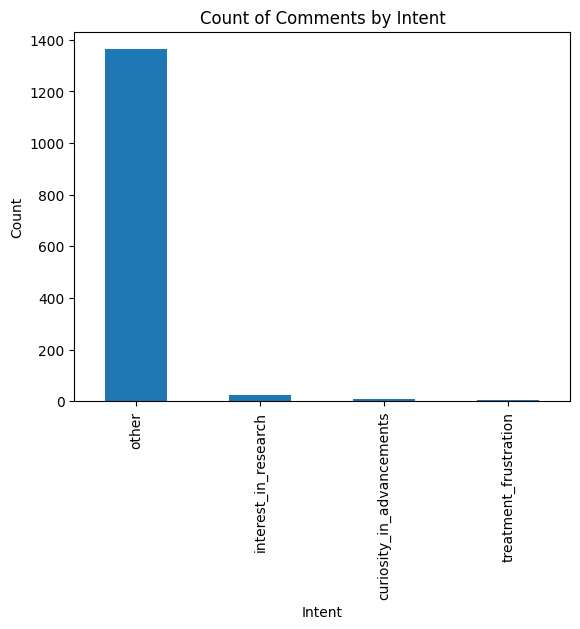

In [19]:
import matplotlib.pyplot as plt

# Count plot for intents
intent_counts = df1['intent'].value_counts()
intent_counts.plot(kind='bar', title='Count of Comments by Intent')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()


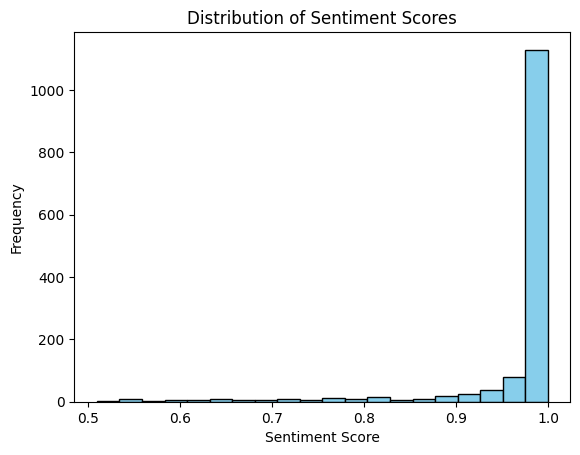

In [20]:
# Distribution of sentiment scores
plt.hist(df1['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


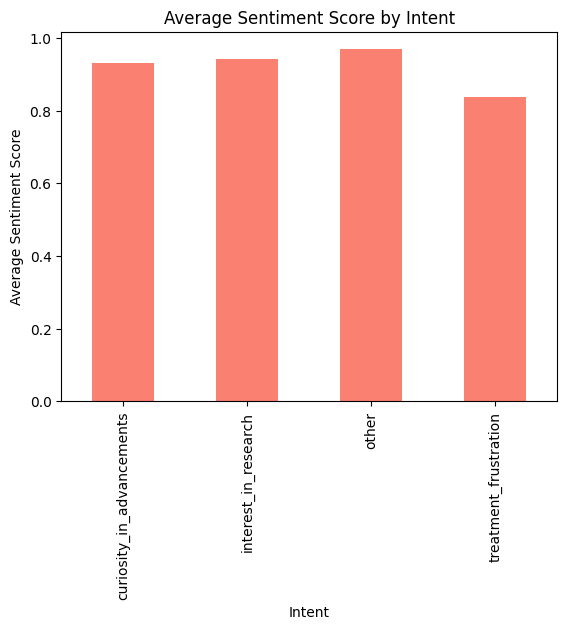

In [21]:
# Average sentiment score per intent
avg_sentiment_per_intent = df1.groupby('intent')['sentiment_score'].mean()

# Bar plot for average sentiment score by intent
avg_sentiment_per_intent.plot(kind='bar', color='salmon')
plt.title('Average Sentiment Score by Intent')
plt.xlabel('Intent')
plt.ylabel('Average Sentiment Score')
plt.show()


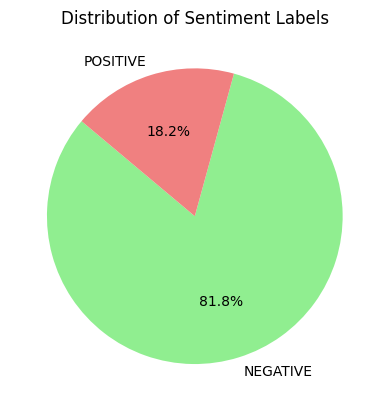

In [22]:
# Count plot for sentiment labels
label_counts = df1['sentiment_label'].value_counts()
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightcoral'])
plt.title('Distribution of Sentiment Labels')
plt.ylabel('')  # Hide the y-label
plt.show()


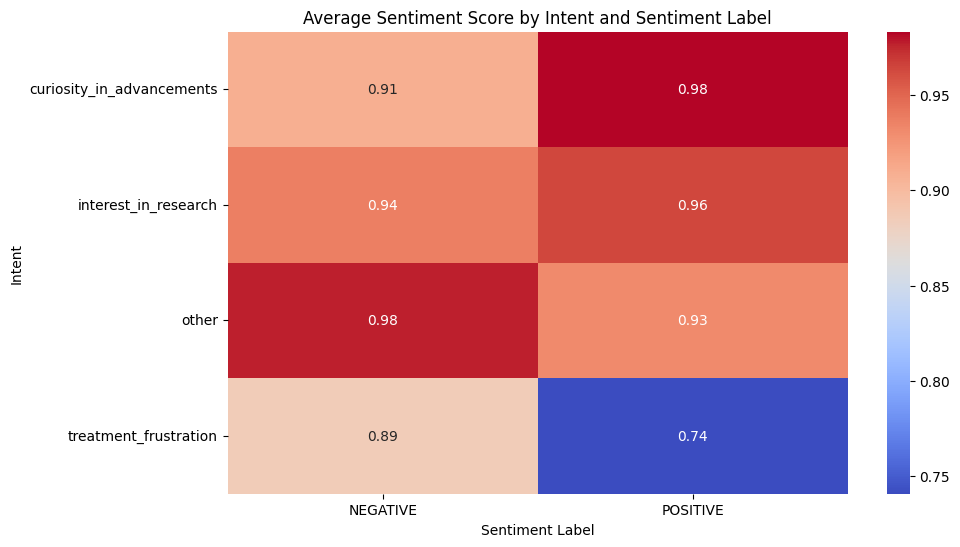

In [23]:
# Average sentiment score by intent and sentiment label
sentiment_by_intent_label = df1.groupby(['intent', 'sentiment_label'])['sentiment_score'].mean().unstack()

# Heatmap of average sentiment score by intent and sentiment label
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_by_intent_label, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Sentiment Score by Intent and Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Intent')
plt.show()


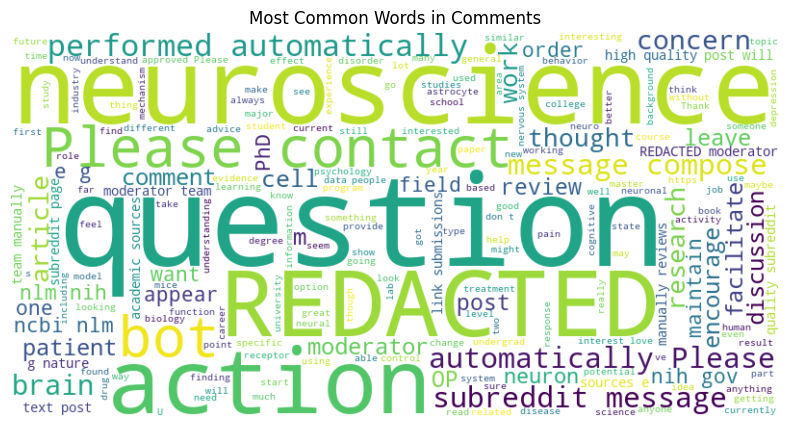

In [24]:
from wordcloud import WordCloud

# Combine all comment text
all_comments = " ".join(df1['comment_body'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Comments')
plt.show()


/var/folders/gy/gfwflynn5vv33mfz9ph39zmc0000gn/T/ipykernel_3095/550964106.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='intent', y='sentiment_score', data=df1, palette="Set3")


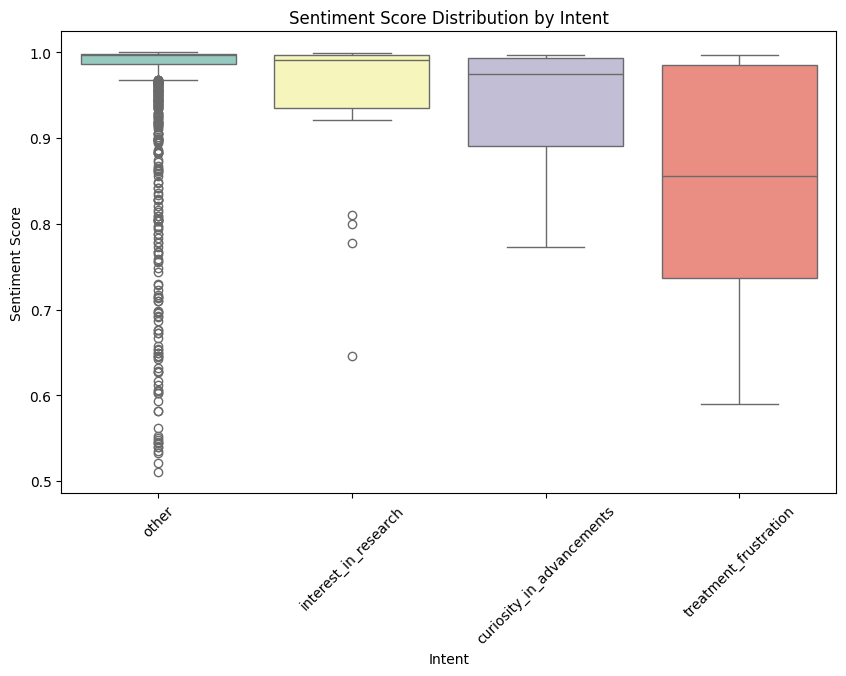

In [25]:
# Boxplot of sentiment scores by intent
plt.figure(figsize=(10, 6))
sns.boxplot(x='intent', y='sentiment_score', data=df1, palette="Set3")
plt.title('Sentiment Score Distribution by Intent')
plt.xlabel('Intent')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()


#### Generating Personalized Messages Using OpenAI

In [47]:
# Load the dataset
df = pd.read_csv("neuroscience_analysis_data.csv")

# Filter for positive sentiment and 'interest_in_research' intent, select the top 5 examples
positive_research_comments = df[
    (df["sentiment_label"].str.strip().str.lower() == "positive") &
    (df["intent"].str.strip().str.lower() == "interest_in_research")
].head(5)

# Display the comment body of the filtered comments
print(positive_research_comments[["comment_body"]])

                                          comment_body
96   "The European Medicines Agency (EMA) did rejec...
177  I always always use human subjects. People are...
190  I don't think anything about human neuroscienc...
683  Hi everyone,\n\nI am soon graduating with a BS...
856  AAV is a great vector for Neuroscience. Our la...


In [49]:
import pandas as pd

# Load the dataset
df = pd.read_csv("neuroscience_analysis_data.csv")

# Filter for positive sentiment and 'interest_in_research' intent, select the top 5 examples
positive_research_comments = df[
    (df["sentiment_label"].str.strip().str.lower() == "positive") &
    (df["intent"].str.strip().str.lower() == "interest_in_research")
].head(5)
def generate_personalized_message(comment):
    prompt = (
        f"The user expressed interest in neuroscience research and wrote: '{comment}'. "
        "Write a friendly, non-intrusive message inviting them to learn more about how they can get involved in neuroscience research."
    )
    
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant specialized in creating personalized outreach messages."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=100,
        temperature=0.7
    )
    
    message = response.choices[0].message['content'].strip()
    return message

# Generate personalized messages for each selected comment
positive_research_comments["personalized_message"] = positive_research_comments["comment_body"].apply(generate_personalized_message)


# Display the DataFrame with the generated messages
print(positive_research_comments[["comment_body", "personalized_message"]])

# Optionally, save the DataFrame to a CSV file
positive_research_comments.to_csv("personalized_messages_simulated.csv", index=False)


                                          comment_body  \
96   "The European Medicines Agency (EMA) did rejec...   
177  I always always use human subjects. People are...   
190  I don't think anything about human neuroscienc...   
683  Hi everyone,\n\nI am soon graduating with a BS...   
856  AAV is a great vector for Neuroscience. Our la...   

                                  personalized_message  
96   Hello! We noticed your interest in neuroscienc...  
177  Hi there! It's great to see your passion for n...  
190  Greetings! Your enthusiasm for neuroscience ca...  
683  Hello! We saw your interest in neuroscience, a...  
856  Hi! It’s inspiring to see your engagement with...  


In [56]:
df2=  pd.read_csv("/Users/gt-europe/Documents/RediQuest-/personalized_messages_simulated.csv")

In [61]:
# Display the first row's comment and personalized message
first_comment = df2.loc[0, "comment_body"]
first_message = df2.loc[0, "personalized_message"]

print("Comment:", first_comment)


Comment: "The European Medicines Agency (EMA) did reject the marketing authorization for lecanemab, citing concerns about the robustness of the evidence and the clinical relevance of the benefits observed."

"Lecanemab has shown some effectiveness in clinical trials, particularly in slowing cognitive decline in patients with early-stage Alzheimer’s disease. In a Phase 3 clinical trial, patients treated with lecanemab experienced a 27% reduction in cognitive decline compared to those receiving a placebo over 18 months. This is a significant finding, but it’s important to note that the drug does not stop or reverse the disease."


In [62]:
print("Personalized Message:", first_message)

Personalized Message: Hello! We noticed your interest in neuroscience research. If you’re open to it, there are exciting ways to get involved in studies exploring this field further. Let us know if you'd like to learn more!
